<a href="https://colab.research.google.com/github/Wayne401-afk/ECG-CNN/blob/main/v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 9.5088e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2143e-04 - val_loss: 8.6617e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.6245e-04 - val_loss: 8.3747e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3874e-04 - val_loss: 8.2130e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0741e-04 - val_loss: 7.9830e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9319e-04 - val_loss: 7.4048e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1424e-04 - val_loss: 6.5603e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3840e-04 - val_loss: 5.9698e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8848e-04 - val_loss: 5.6065e-04
Epoch

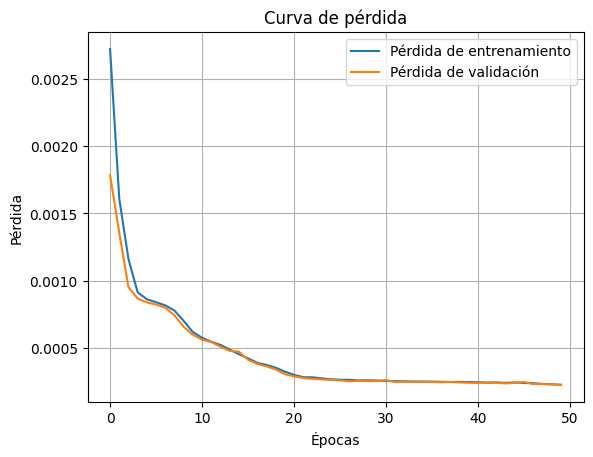

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


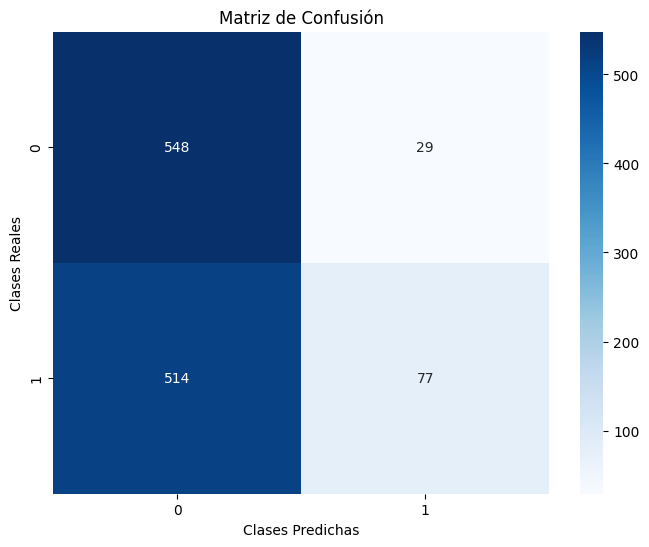

Confusion Matrix:
 [[548  29]
 [514  77]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.95      0.67       577
         1.0       0.73      0.13      0.22       591

    accuracy                           0.54      1168
   macro avg       0.62      0.54      0.44      1168
weighted avg       0.62      0.54      0.44      1168



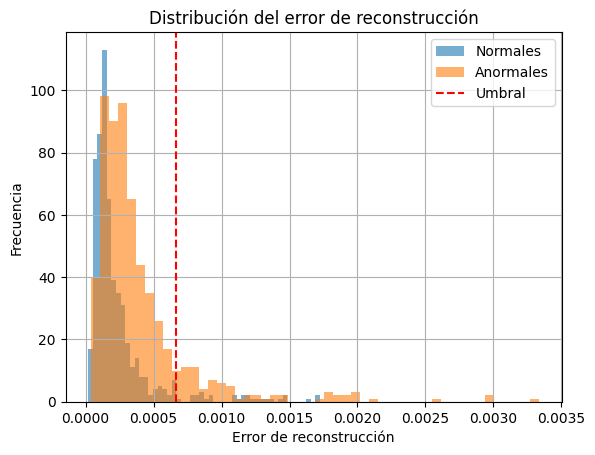

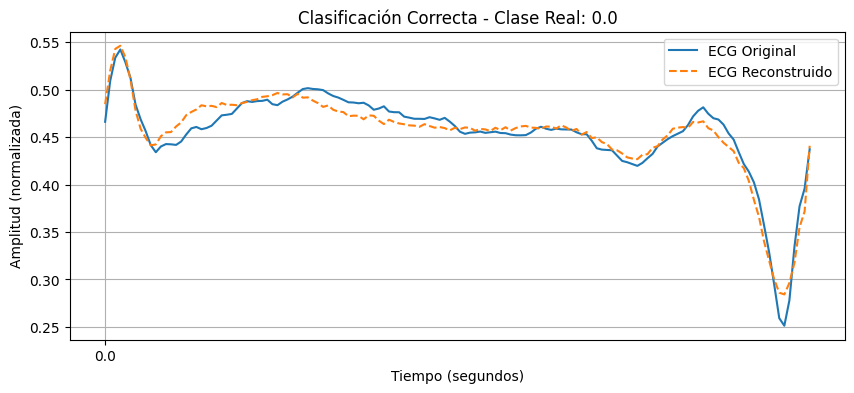

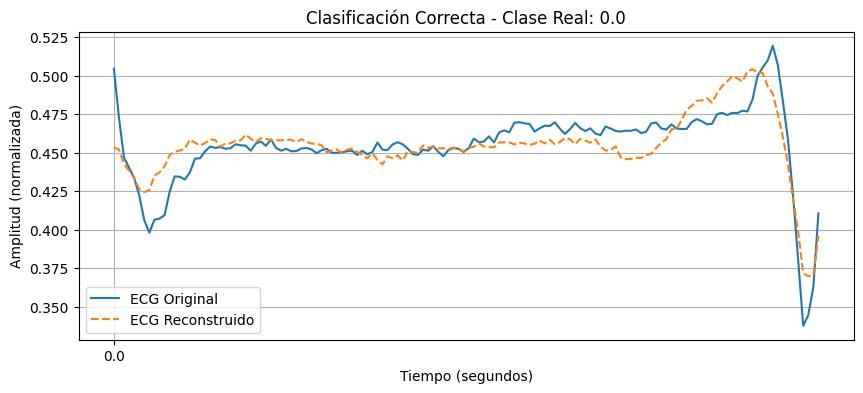

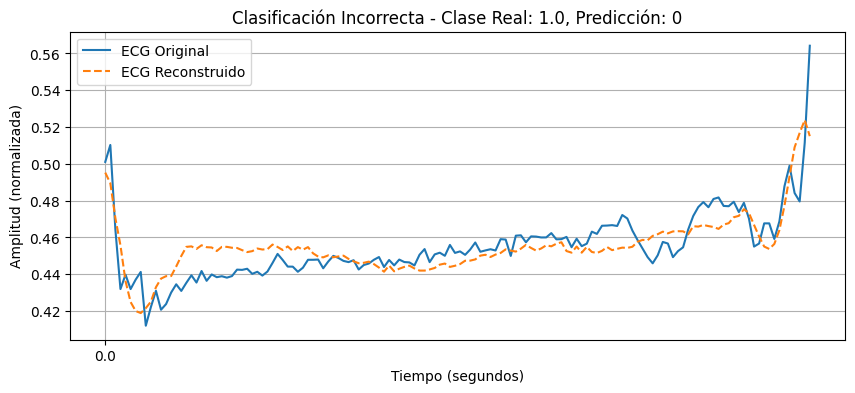

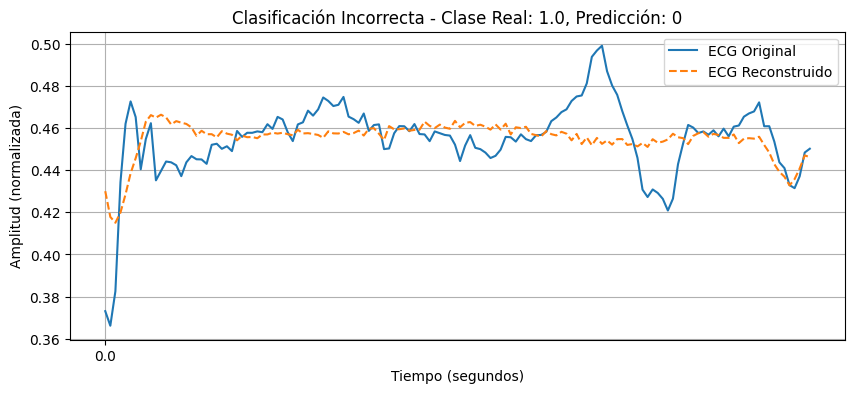

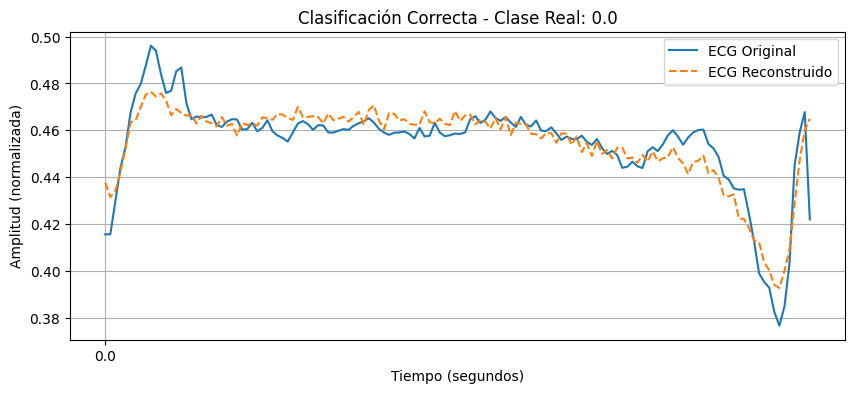

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from scipy.signal import butter, filtfilt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import plotly.express as px

# Función para aplicar filtros pasa-bajos y pasa-altos
# Filtrado digital para preprocesar señales ECG

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_filter(data, fs, lowcut=0.5, highcut=60, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=0)

# Definir la frecuencia de muestreo
fs = 500  # Frecuencia de muestreo en Hz

# Cargar la data desde la URL
url = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
ecg_data = pd.read_csv(url)

# Preparar los datos
X = ecg_data.iloc[:, :-1].values  # Señales (todas las columnas excepto la última)
y = ecg_data.iloc[:, -1].values   # Etiquetas (última columna)

# Filtrar señales
X = apply_filter(X, fs)

# Normalizar las señales
X = X.astype("float32")
X = (X - np.min(X)) / (np.max(X) - np.min(X))

# Dividir en señales normales (y=0) y anormales (y=1)
X_normal = X[y == 0]
X_anomalous = X[y == 1]

# Manejo de desbalance con SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Dividir datos balanceados en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_balanced)
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['Etiqueta'] = y_balanced

fig = px.scatter(df_pca, x='PCA1', y='PCA2', color='Etiqueta', title='Visualización PCA de Señales ECG')
fig.show()

# Arquitectura del Autoencoder
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        # Codificador
        self.encoder = tf.keras.Sequential([
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu")
        ])
        # Decodificador
        self.decoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(X.shape[1], activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Crear el modelo
autoencoder = AnomalyDetector()

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar el modelo con datos normales
history = autoencoder.fit(X_train[y_train == 0], X_train[y_train == 0],
                          epochs=50,
                          batch_size=64,
                          validation_split=0.2,
                          shuffle=True)

# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de pérdida')
plt.legend()
plt.grid()
plt.show()

# Evaluar el modelo
X_test_normal = X_test[y_test == 0]
X_test_anomalous = X_test[y_test == 1]
X_reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.power(X_test - X_reconstructed, 2), axis=1)

# Determinar el umbral para clasificar anomalías
threshold = np.percentile(reconstruction_error[y_test == 0], 95)  # Por ejemplo, el 95% de los errores más bajos

# Clasificar los datos
y_pred = (reconstruction_error > threshold).astype(int)

# Métricas de evaluación
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Reales')
plt.show()

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Visualizar el error de reconstrucción
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.6, label='Normales')
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.6, label='Anormales')
plt.axvline(threshold, color='r', linestyle='--', label='Umbral')
plt.xlabel('Error de reconstrucción')
plt.ylabel('Frecuencia')
plt.title('Distribución del error de reconstrucción')
plt.legend()
plt.grid()
plt.show()

# Graficar ejemplos de señales clasificadas correctamente y erróneamente
time_axis = np.linspace(0, X_test.shape[1] / fs, X_test.shape[1])
time_axis = np.arange(0, len(time_axis))

for i in range(5):
    plt.figure(figsize=(10, 4))
    if y_test[i] == y_pred[i]:
        plt.title(f"Clasificación Correcta - Clase Real: {y_test[i]}")
    else:
        plt.title(f"Clasificación Incorrecta - Clase Real: {y_test[i]}, Predicción: {y_pred[i]}")
    plt.plot(time_axis, X_test[i], label='ECG Original')
    plt.plot(time_axis, X_reconstructed[i], linestyle='--', label='ECG Reconstruido')
    plt.xticks(np.arange(0, len(time_axis), fs), np.arange(0, len(time_axis) / fs, 1))
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Amplitud (normalizada)')
    plt.legend()
    plt.grid()
    plt.show()
